In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
#Importing libraries
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import os
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import keras.callbacks 
from keras.utils.np_utils import to_categorical

# **Opening .json file**

In [4]:
f = open(r'../input/ships-in-satellite-imagery/shipsnet.json')
dataset = json.load(f)
f.close()

#  **Converting data from list to np.array**

In [5]:
data = np.array(dataset['data']).astype('uint8')
labels = np.array(dataset['labels']).astype('uint8')

In [6]:
#Printing shape
print(data.shape)
print(labels.shape)

(4000, 19200)
(4000,)


In [11]:
#Normalizing the data and transform data to keras model
x = data / 255.
x = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
print(x.shape)
y = to_categorical(labels, num_classes=2)
print(y.shape)

(4000, 80, 80, 3)
(4000, 2)


In [14]:
base_dir = '../input/ships-in-satellite-imagery'
train_dir = os.path.join(base_dir,'shipsnet')
validation_dir = os.path.join(base_dir,'shipsnet')
#training with snest and scense images
train_shipsnet=os.path.join(train_dir,'shipsnet')
validation_shipsnet=os.path.join(validation_dir,'shipsnet')

In [16]:
data_file_dir = os.listdir(train_shipsnet)
data_file_dir[:4]

['1__20180708_180909_0f47__-118.21792579242826_33.738166018341566.png',
 '1__20170618_180802_0f34__-122.33162556867539_37.71777932578817.png',
 '1__20171025_175647_0e26__-118.14347911930842_33.73362914920917.png',
 '1__20170604_180820_0f52__-122.3244485879647_37.728446060102726.png']

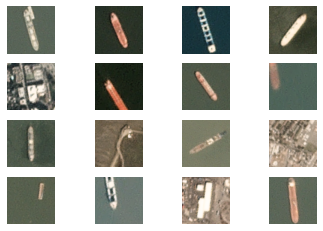

In [17]:
#Visualisation of images
import matplotlib.pyplot as plt
j=1 #plot position
for i in range(16):
  img = plt.imread(os.path.join(train_shipsnet,data_file_dir[i]))
  plt.subplot(4,4,j)
  plt.imshow(img)
  plt.axis('off')
  j+=1

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 4000 images belonging to 1 classes.
Found 4000 images belonging to 1 classes.


In [19]:
#Building Model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=(80, 80, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), 
              metrics=['accuracy'])

In [20]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 78, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 39, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 64)        0

In [21]:
#Training the model using 20 % of data used in validation
history = model.fit(x, y, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
100/100 [==============================] - 54s 538ms/step - loss: 0.5325 - accuracy: 0.7653 - val_loss: 1.8359 - val_accuracy: 0.3787
Epoch 2/20
100/100 [==============================] - 54s 542ms/step - loss: 0.1953 - accuracy: 0.9219 - val_loss: 0.5589 - val_accuracy: 0.6862
Epoch 3/20
100/100 [==============================] - 55s 546ms/step - loss: 0.1196 - accuracy: 0.9522 - val_loss: 1.0324 - val_accuracy: 0.5350
Epoch 4/20
100/100 [==============================] - 54s 545ms/step - loss: 0.0902 - accuracy: 0.9678 - val_loss: 0.5145 - val_accuracy: 0.7663
Epoch 5/20
100/100 [==============================] - 54s 538ms/step - loss: 0.0723 - accuracy: 0.9772 - val_loss: 0.7783 - val_accuracy: 0.7575
Epoch 6/20
100/100 [==============================] - 54s 538ms/step - loss: 0.0626 - accuracy: 0.9794 - val_loss: 0.2784 - val_accuracy: 0.9125
Epoch 7/20
100/100 [==============================] - 58s 580ms/step - loss: 0.0457 - accuracy: 0.9819 - val_loss: 0.2743 - val_ac